Data set from https://www.physionet.org/content/eegmmidb/1.0.0/ recordings from 109 volunteers 

### **Experiment Protocol**

performed 14 experimental runs:
1. **one-minute** baseline runs with eyes open.
2. **one-minute** baseline runs with eyes closed.
3. Task 1 : **two-minute** open and close left or right fist
4. Task 2 : **two-minute** imagine opening and closing left or right fist
5. Task 3 : **two-minute** open and close both fists or both feet
6. Task 4 : **two-minute** imagine opening and closing both fists or both feet
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

**Annotation three codes** (T0, T1, or T2):
- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of
    - the left fist (in runs 3, 4, 7, 8, 11, and 12)
    - both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
    - the right fist (in runs 3, 4, 7, 8, 11, and 12)
    - both feet (in runs 5, 6, 9, 10, 13, and 14)

# **Offline processing of Motor Imagery**

## **Pre-Processing**

### **Load Data**

In [1]:
%matplotlib inline
import mne
import os
import pyedflib
import pandas as pd
import numpy as np
import seaborn as sns
from mne.io import read_raw_edf, RawArray, concatenate_raws
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

In [2]:
# --- Data Details --- 
subject_id = ["001"]
task_id = ["04", "08", "12"]

# --- Set Montage ---
montage_name = 'standard_1020'

# --- Set Channels Select ---
chans_selected = ['C5','C3','C1','Cz','C2','C4','C6']

In [3]:
# --- Dataset Path --- 
dataset_path = "Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files"

# --- Full Path ---
filenames = []
for i in range(len(subject_id)):
    for j in range(len(task_id)):
        filenames.append("S"+subject_id[i]+"/S"+subject_id[i]+"R"+task_id[j]+".edf")
        
path = [os.path.join(dataset_path, filename).replace("\\", "/") for filename in filenames]

# --- Read EDF Files ---
subject_raws = []
for file_path in path:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    subject_raws.append(data)

print("Path:",path)
raws_data = concatenate_raws(subject_raws)
print("RawEDF data:", raws_data)

# --- Check Signal Channels ---
with pyedflib.EdfReader(path[-1]) as edf_file:
    signal_labels = edf_file.getSignalLabels()
    print("signal_channels:", signal_labels)

Path: ['Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R04.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R08.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R12.edf']
RawEDF data: <RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>
signal_channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']


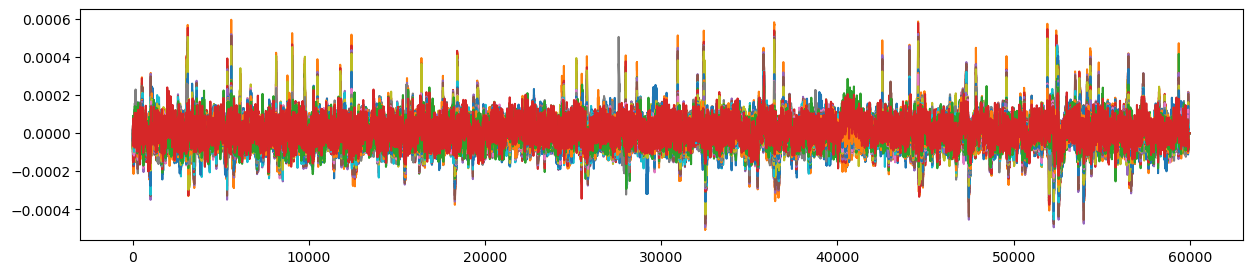

In [4]:
# --- Plot Raw Data in Time Domain ---
# raws_data.plot()
data = raws_data.get_data()
plt.figure(figsize=(15,3))
plt.plot(data.T)

Effective window size : 12.800 (s)


C:\Users\user\AppData\Local\Temp\ipykernel_24836\2751059171.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raws_data.compute_psd().plot();
c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


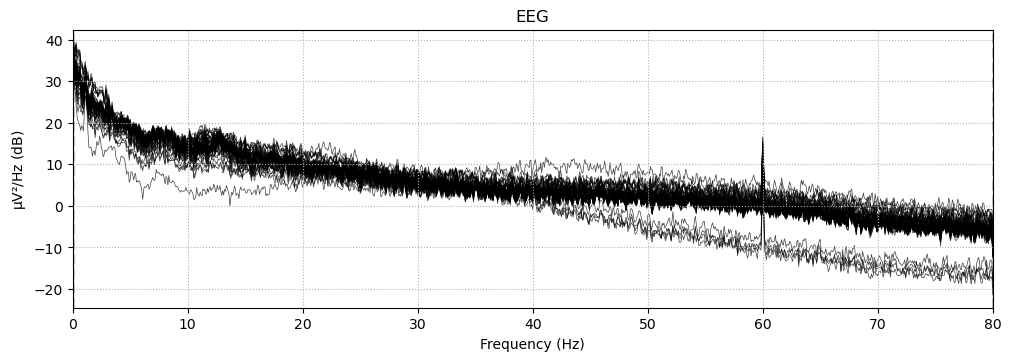

In [5]:
# --- Plot Raw Data in Frequency Domain ---
raws_data.compute_psd().plot();

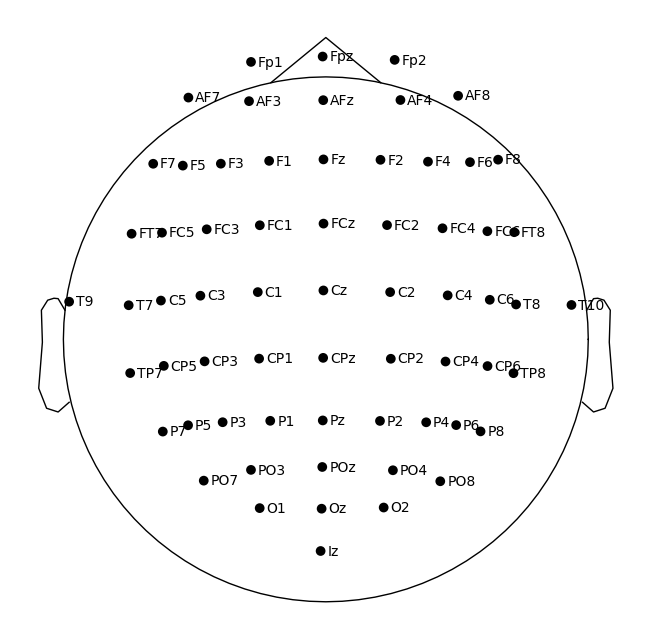

In [6]:
with open("Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/wfdbcal", "r") as file:
    content = file.readlines()
    
chan_name = []
chan_order = []
chan_mapping = {}
order = 1
for line in content:
    parts = line.split('\t')
    channel_name = parts[0].strip()
    channel_name = channel_name.replace(".", "")
    chan_name.append(channel_name)
    order_name = "# " + str(order)
    chan_order.append(order_name)
    chan_mapping[order_name] = channel_name
    order += 1 

channel_names = [chan_mapping[f'# {i+1}'] for i in range(64)]
old_ch_names = raws_data.info['ch_names']

raws_data.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})

# Set montage
# montage = mne.channels.make_standard_montage('standard_1020')
raws_data.set_montage(montage = mne.channels.make_standard_montage(montage_name))

# Plot channel locations
raws_data.plot_sensors(show_names=True);

Effective window size : 12.800 (s)


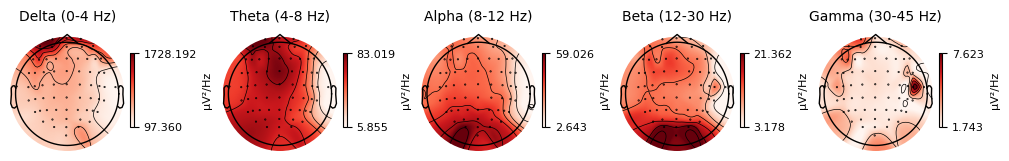

In [7]:
raws_data.compute_psd().plot_topomap();

### **Re-referencing**

Original data of brain signal (64 channels)

Effective window size : 12.800 (s)


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


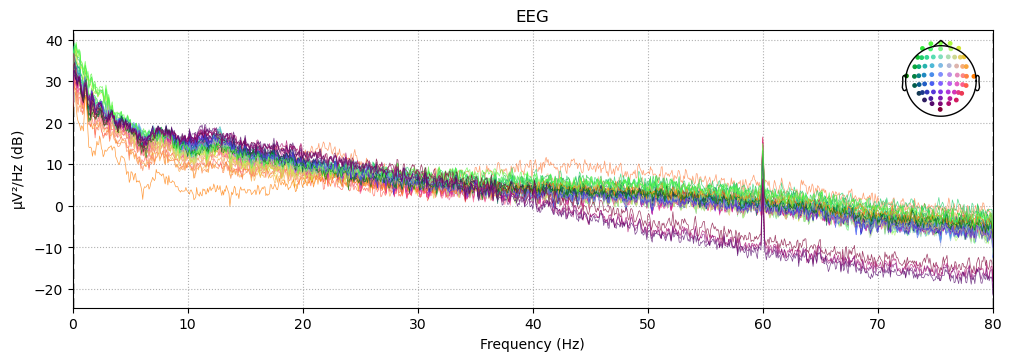

In [8]:
# --- Plot Raw Data in Time Domain ---
raws_data.compute_psd().plot();

**Common Average Reference (CAR)** for re-referancing signal 64 channels

In [9]:
# --- Apply Re-reference by Common Average Reference (CAR) ---
streams = raws_data.copy().set_eeg_reference('average', projection=True)
streams.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

Once re-referencing is done, it's apparent that there are channels moving closer to other graphs, as seen clearly. For instance, the purple graph overlaps and closely aligns with other graphs significantly.

Effective window size : 12.800 (s)


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


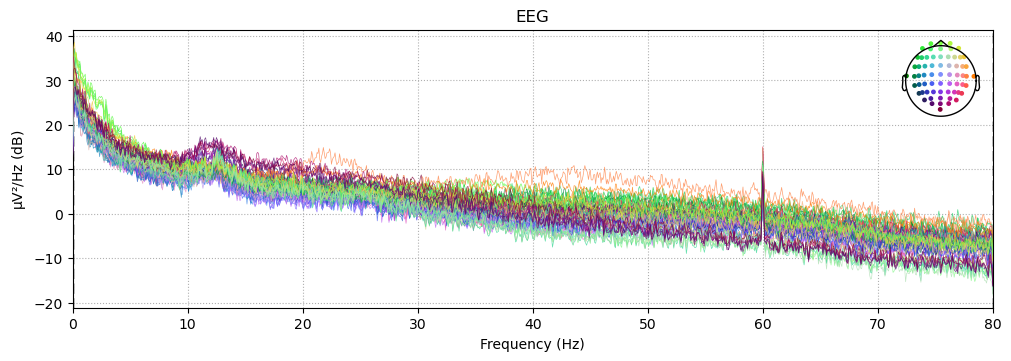

In [10]:
streams.compute_psd().plot();

### **Filtering**

**Infinite Impulse Response (IIR)** for filtering signal
- Butterworth Filters and 6 order
- Low frequency = 8.0
- High frequency = 15.0

In [11]:
stream_filter = streams.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB



Effective window size : 12.800 (s)


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


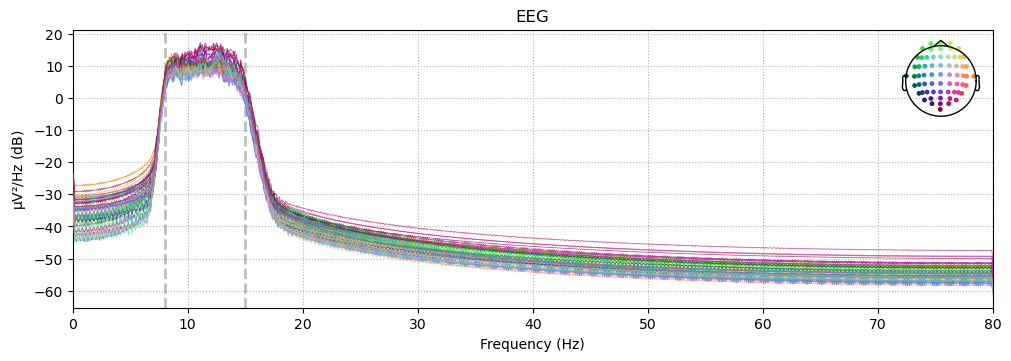

In [12]:
stream_filter.compute_psd().plot();
# stream_filter.plot();

### **Artifact rejection and correction**

**Independent Component Analysis (ICA)** for remove artifact from eye blink or other artifact 

In [13]:
# --- Apply ICA ---
ica = mne.preprocessing.ICA(n_components=63, random_state=97, max_iter=800)
ica.fit(stream_filter.copy())

Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 63 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 7.0s.


<ICA | raw data decomposition, method: fastica (fit in 161 iterations on 60000 samples), 63 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

plot topographies of the ICA components to observe and identify which components are likely to be artifacts, in order to use them for removing those specific components, for the purpose of artifact removal

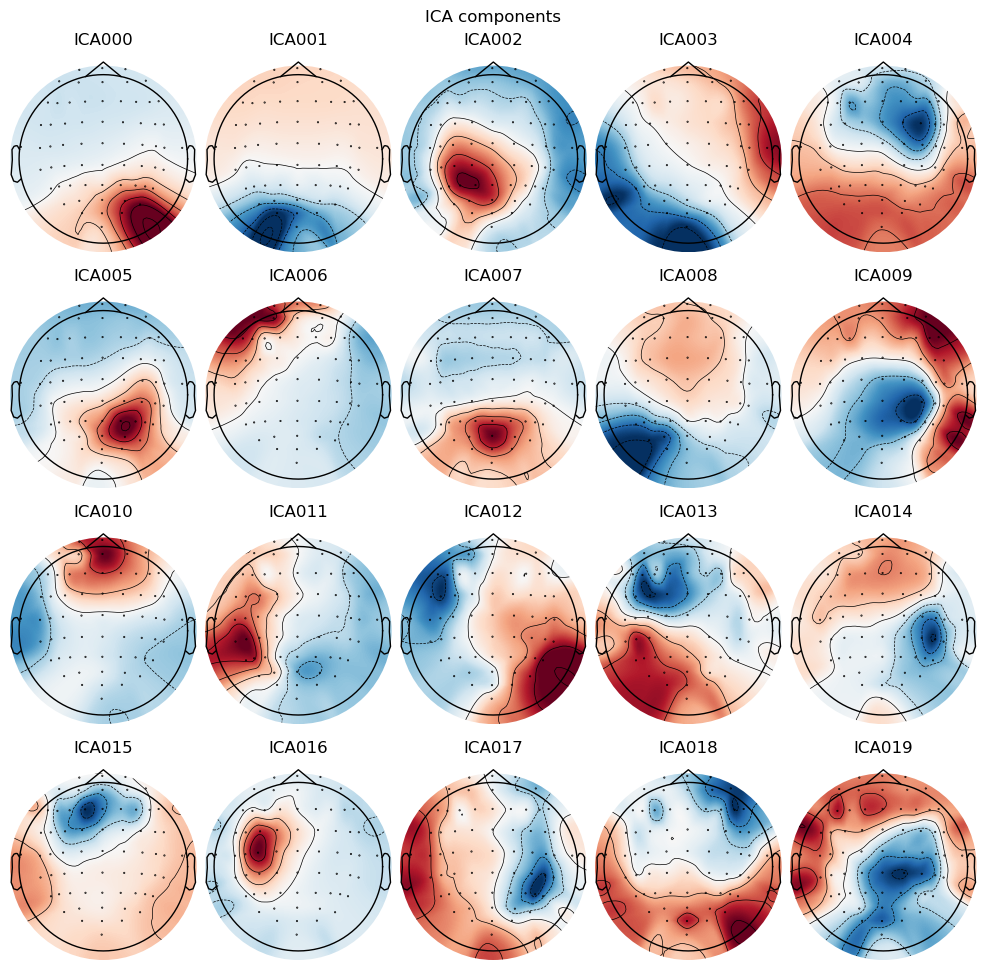

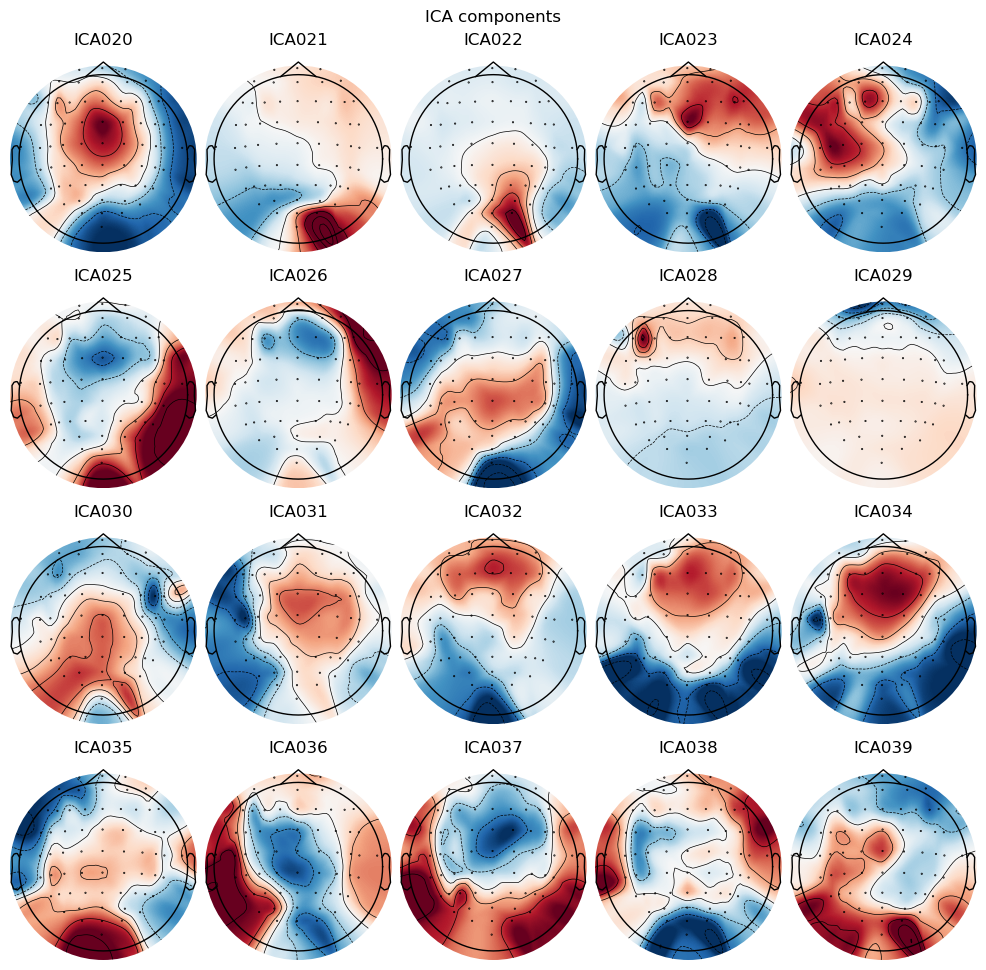

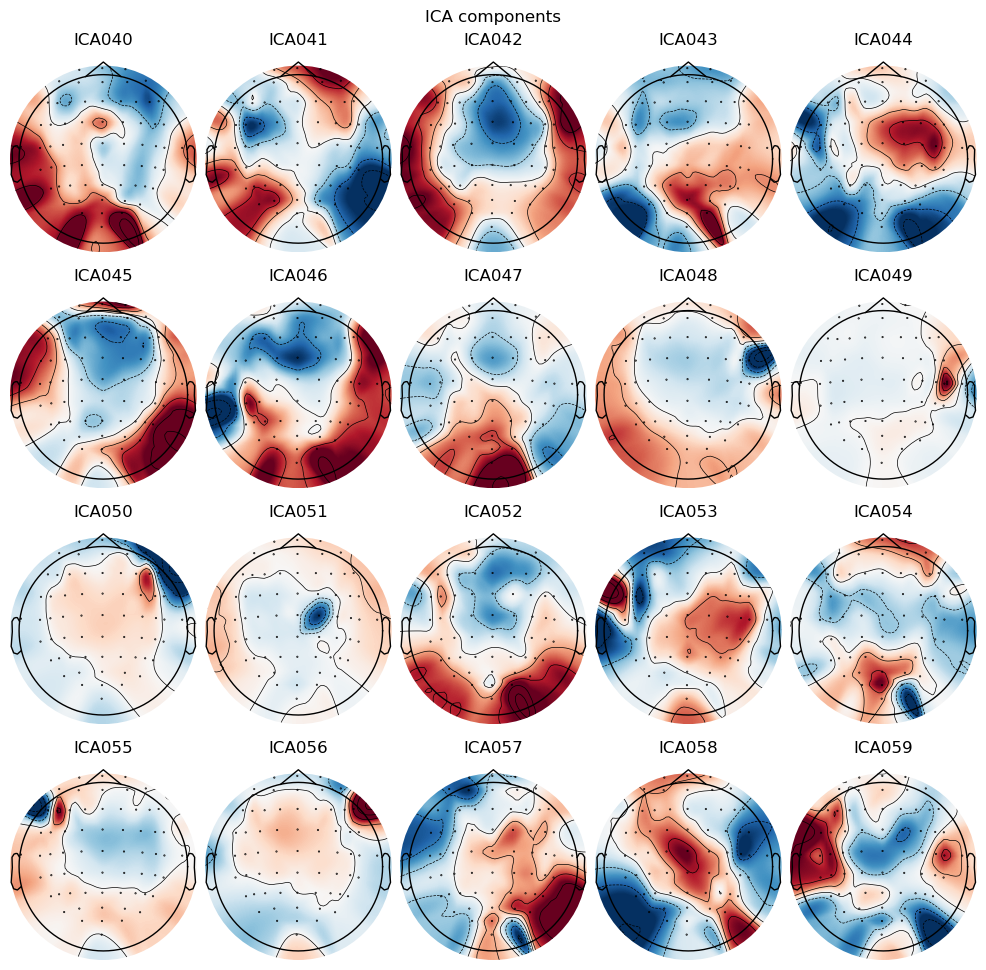

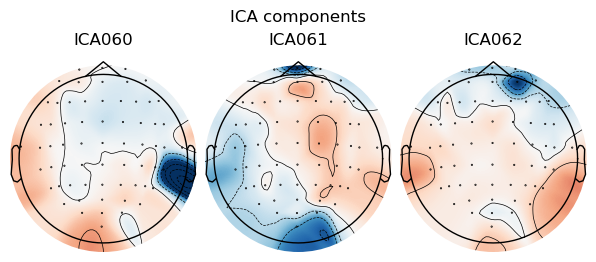

In [14]:
# --- Plot ICA Components ---
ica.plot_components();

Find bad component or artifact component by visual inspection and remove it from the data

In [15]:
# --- Find Bad Components ---
bad_idx, scores = ica.find_bads_eog(stream_filter.copy(), ch_name='T9', threshold=1.5)

Using EOG channel: T9
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- U

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [16]:
# --- Remove Bad Components ---
ica.exclude = bad_idx
print(bad_idx)

# --- Plot ICA Components ---
ica.plot_sources(stream_filter.copy());
#stream_filter.plot();

[3, 12, 2, 17, 20, 27, 10, 15, 35, 42, 7, 40, 0, 31]
    Applying projection operator with 1 vector (pre-whitener application)


Creating RawArray with float64 data, n_channels=63, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   374.994 secs
Ready.
Using qt as 2D backend.


In [17]:
# --- Apply ICA to Filtered Data ---
stream_ica = ica.apply(stream_filter.copy(),exclude=ica.exclude)
#stream_ica.plot();

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (63 components)


    Zeroing out 14 ICA components
    Projecting back using 64 PCA components


### **Epoch segmentation**

#### **Event marker**

Each event from signal
- T0 = rest
- T1 = Left hand motor imagery
- T2 = Right hand motor imagery

sfreq 160.0
Used Annotations descriptions: ['T0', 'T1', 'T2']
{'T0': 1, 'T1': 2, 'T2': 3}


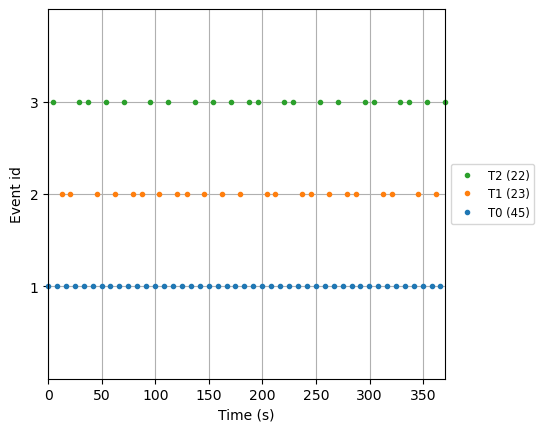

C:\Users\user\AppData\Local\Temp\ipykernel_24836\3407552309.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [18]:
# --- Events ---
print("sfreq", stream_filter.info["sfreq"])
events, event_dict = mne.events_from_annotations(stream_filter)
print(event_dict)

# --- Plot Events ---
fig = mne.viz.plot_events(
    events, sfreq=stream_filter.info["sfreq"], first_samp=stream_filter.first_samp, event_id= event_dict
)
ax = fig.axes[0]
x_lim_seconds = [10, 20]
ax.set_xlim(x_lim_seconds)
fig.show()

#### **Epochs**

In [19]:
# Epoch data based on a subset of interested events
event_selected_mi = {'left': 2, 'right': 3}
event_selected_nonmi = {'rest':1, 'left': 2, 'right': 3}

epochs_mi = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -2.0, tmax = 5, 
                    event_id = event_selected_mi, preload= True, verbose=False, event_repeated='drop')

epochs_nonmi = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -2.0, tmax = 5, 
                    event_id = event_selected_nonmi, preload= True, verbose=False, event_repeated='drop')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB



In [20]:
epochs_mi
epochs_mi.info

<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 8.0 Hz
 lowpass: 15.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: Average EEG reference: on
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

In [21]:
epochs_nonmi
epochs_nonmi.info

<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 8.0 Hz
 lowpass: 15.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: Average EEG reference: on
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

In [22]:
epochs_mi.to_data_frame()

time condition  epoch       FC5       FC3       FC1       FCz  \
0     -2.00000     right      1  2.362628  2.409247 -0.731812 -0.984998   
1     -1.99375     right      1  3.630020  1.752413 -2.098767 -2.015024   
2     -1.98750     right      1  4.348038  0.907098 -2.707020 -2.177585   
3     -1.98125     right      1  4.298972  0.020806 -2.487275 -1.553963   
4     -1.97500     right      1  3.419394 -0.781219 -1.604484 -0.450950   
...        ...       ...    ...       ...       ...       ...       ...   
47077  4.97500      left     87 -1.980468 -1.358340 -1.650885 -1.101771   
47078  4.98125      left     87  0.243485  2.711626  1.807861 -0.453571   
47079  4.98750      left     87  2.550110  6.348746  5.055198  0.514114   
47080  4.99375      left     87  4.318316  8.699009  7.311101  1.545893   
47081  5.00000      left     87  5.047855  9.187898  8.007354  2.351089   

            FC2        FC4        FC6  ...        P8       PO7       PO3  \
0     -4.460526  -2.698817  -0.466380  ... -4.216799  3.228398  2.337357   
1     -3.563960  -1.267768   0.577991  ... -4.283578  1.644967  0.915000   
2     -1.595433   0.833557   1.973596  ... -3.526639 -1.418231 -1.843967   
3      0.861757   2.951479   3.213822  ... -2.127622 -4.908408 -4.951257   
4      3.092202   4.405326   3.788771  ... -0.410757 -7.553458 -7.210281   
...         ...        ...        ...  ...       ...       ...       ...   
47077 -5.352390  -3.374464   1.041010  ...  3.234942  0.785194  0.525269   
47078 -6.566457  -7.761239  -3.841810  ...  0.054542  2.260538  1.760520   
47079 -6.296220 -10.590564  -8.114994  ... -2.812615  3.613497  2.953160   
47080 -4.633593 -11.287030 -10.757798  ... -4.637353  4.467514  3.763459   
47081 -1.986071  -9.715288 -11.073686  ... -4.997018  4.488989  3.870311   

            POz       PO4       PO8         O1         Oz         O2        Iz  
0     -5.400077 -6.695401 -3.784527   0.957276  -1.703671  -0.620002  0.967045  
1     -7.415967 -8.346739 -5.345501  -2.229252  -6.013945  -4.488615 -0.886415  
2     -8.599889 -8.517506 -6.035910  -6.185937  -9.785979  -8.055789 -3.053100  
3     -8.502313 -7.109329 -5.624994  -9.659012 -12.048930 -10.471689 -4.978286  
4     -6.875336 -4.347252 -4.115921 -11.354471 -12.073869 -11.090027 -6.102594  
...         ...       ...       ...        ...        ...        ...       ...  
47077 -0.807689 -1.315585  1.659879  -0.902172  -0.202014  -2.442781  3.878396  
47078  1.301292 -0.667902  0.015444   1.027523   2.385040  -0.219261  4.207372  
47079  3.216321  0.058451 -1.321687   3.358907   5.029355   2.271484  4.116593  
47080  4.620303  0.855713 -1.956536   5.516558   7.151638   4.692990  3.596060  
47081  5.267896  1.687145 -1.720409   6.850670   8.201913   6.677084  2.673917  

[47082 rows x 67 columns]

In [23]:
# Selected data from only the channels we are interested in
epochs_mi = epochs_mi.pick_channels(chans_selected)
epochs_nonmi = epochs_nonmi.pick_channels(chans_selected)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


    Using multitaper spectrum estimation with 7 DPSS windows


Averaging across epochs...


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


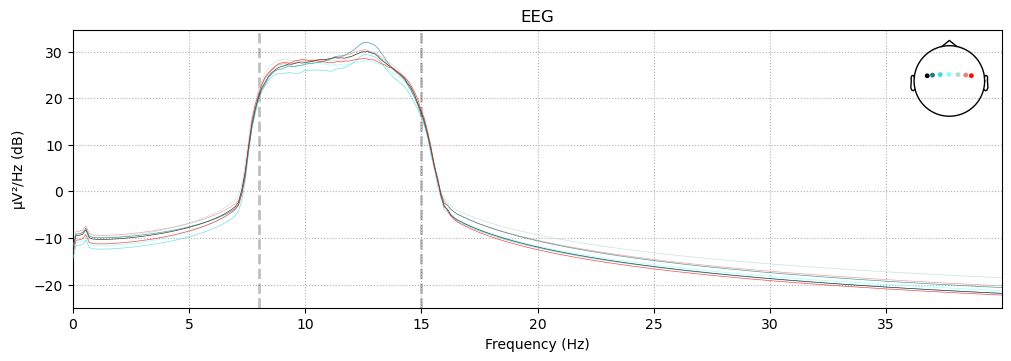

In [24]:
#stream_epochs.plot();
epochs_mi.compute_psd(fmin=0, fmax=40).plot();

### **Baseline Correction**

In [25]:
filt_mi = epochs_mi.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
filt_nonmi = epochs_nonmi.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
# filt_mi.plot();
# filt_nonmi.plot();

Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB



In [26]:
stream_mi = filt_mi.copy().apply_baseline((-0.5, 0))
stream_nonmi = filt_nonmi.copy().apply_baseline((-0.5, 0))
stream_mi.plot();

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


### **Bad epochs**

#### **Marking bad epochs**

In [27]:
def mark_bad_epochs(epochs, threshold=200e-6):
    reject = dict(eeg=threshold)
    reject.update({'eeg': 150e-6})
    epochs.drop_bad(reject=reject)
    return epochs

mark_bad_epochs(stream_mi.copy())
mark_bad_epochs(stream_nonmi.copy())

0 bad epochs dropped
0 bad epochs dropped


<Epochs |  84 events (all good), -2 – 5 s, baseline -0.5 – 0 s, ~5.1 MB, data loaded,
 'rest': 42
 'left': 21
 'right': 21>

#### **Tuning rejection thresholds**

In [28]:
from ipywidgets import interact

def reject_epochs(reject):
    pick = mne.pick_types(stream_mi.info, meg=False, eeg=True)
    reject = dict(eeg=reject*1e-6)
    evoked = stream_mi.copy().drop_bad(reject=reject, verbose=False).average()
    evoked.plot(spatial_colors=True, gfp=True, time_unit='s')
    print('Number of epochs retained: %d%d' % (evoked.nave, len(stream_mi)))

In [29]:
interact(reject_epochs, reject=(35, 250, 10));

interactive(children=(IntSlider(value=135, description='reject', max=250, min=35, step=10), Output()), _dom_cl…

#### **Autoreject**

In [30]:
import autoreject
from autoreject import get_rejection_threshold

def autoreject_epochs(epochs):
    reject = get_rejection_threshold(epochs)  
    reject.update(reject)
    epochs.drop_bad(reject = reject)
    return epochs

autoreject_epochs(stream_mi.copy())
autoreject_epochs(stream_nonmi.copy())

Estimating rejection dictionary for eeg
0 bad epochs dropped
Estimating rejection dictionary for eeg
0 bad epochs dropped


<Epochs |  84 events (all good), -2 – 5 s, baseline -0.5 – 0 s, ~5.1 MB, data loaded,
 'rest': 42
 'left': 21
 'right': 21>

## **Feature Extraction**

### **Common Spatial Pattern (CSP)**

In [31]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split, cross_val_score

Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 7 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 7 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


C:\Users\user\AppData\Local\Temp\ipykernel_24836\2848526005.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


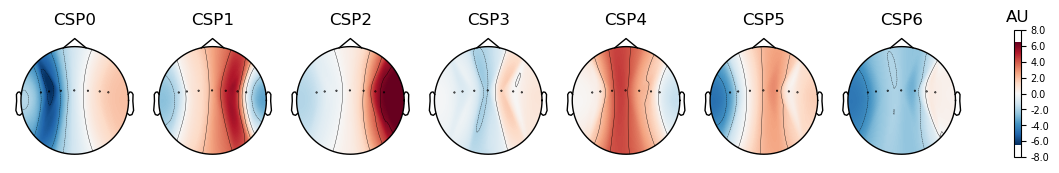

CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 7,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})
Computing rank from data with rank=None
    Using tolerance 3e-06 (2.2e-16 eps * 7 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 7 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 7 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducin

C:\Users\user\AppData\Local\Temp\ipykernel_24836\2848526005.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


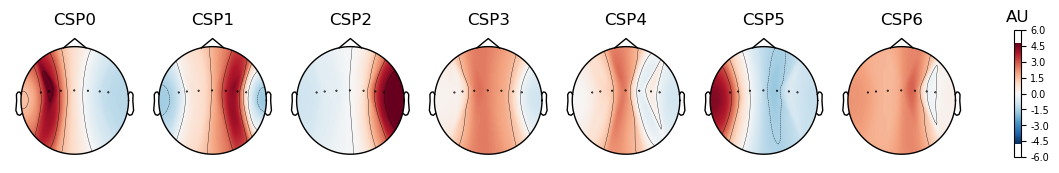

CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 7,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})


In [32]:
def csp(epochs, n_component = 7): 
    X = epochs.get_data()
    y = epochs.events[:, -1]
    
    # Initilize CSP
    csp = CSP(n_components = n_component, norm_trace = False)
    
    # Fit CSP to data 
    csp.fit(X, y)
    
    # Visualize CSP patterns
    csp.plot_patterns(epochs.info);
    print(csp)
    return X, y, csp
    
X_mi, y_mi, csp_mi = csp(stream_mi.copy(), 7)
X_nonmi, y_nonmi, csp_nonmi = csp(stream_nonmi.copy(),7)

## **Feature Selection** 

https://johfischer.com/2021/08/06/correlation-based-feature-selection-in-python-from-scratch/

Use Correlation-based Feature Selection for select feature 

Calculate merit for check correlation between class-feature and feature-feature

In [33]:
from scipy.stats import pointbiserialr
from math import sqrt

def getMerit(subset, label):
    print(subset)
    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr( df[label], df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()
    
    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [34]:
import pandas as pd
import numpy as np

X_transformed = csp_mi.transform(X_mi)
# Assuming X_transformed is a NumPy array
df = pd.DataFrame(X_transformed)
print(df)

# Compute correlation matrix
corr = df.corr()

# corr

           0         1         2         3         4         5         6
0  -1.267325 -1.140497 -0.264565 -0.503213 -0.614549 -0.599776 -0.910099
1  -1.332538 -1.440485 -0.550716 -0.813426 -0.649025 -0.651575 -0.576702
2  -0.148381 -0.487752 -0.518904 -0.793969 -0.492271 -0.667331 -0.422571
3  -1.159433 -0.658083 -0.503672 -1.036493 -0.625562 -0.656814 -0.793220
4  -1.485491 -0.910048 -1.205213 -0.754574 -1.113732 -0.938464 -0.722990
5  -0.352888 -0.927358 -0.703452 -0.598307 -0.375869 -0.625705 -0.769289
6  -0.456807 -0.385646 -0.330635 -0.688858 -0.711883 -0.636259 -0.812562
7  -0.126055 -0.957333 -0.822810 -0.621736 -0.603711 -0.707952 -0.502118
8  -1.383160 -0.783593 -0.716888 -0.825006 -0.858844 -0.665287 -0.527395
9  -0.268858 -1.350773 -1.202129 -0.508972 -0.532377 -0.915547 -0.550047
10 -0.599879 -0.989852 -0.938352 -0.428812 -0.626401 -0.271737 -0.590636
11 -0.300109 -0.499618 -0.372820 -1.038133 -0.732835 -0.688202 -0.740907
12 -0.455107 -0.593342 -0.776532 -0.807935 -0.43477

In [35]:
corr.values[np.tril_indices_from(corr.values)] = np.nan
corr

0         1         2         3         4         5         6
0 NaN  0.330648  0.327991  0.381164  0.513951  0.416329  0.166190
1 NaN       NaN  0.614282 -0.044313  0.194577  0.296041  0.266303
2 NaN       NaN       NaN -0.105002  0.426959  0.416463  0.072365
3 NaN       NaN       NaN       NaN  0.062043  0.288276  0.165116
4 NaN       NaN       NaN       NaN       NaN  0.136195  0.055242
5 NaN       NaN       NaN       NaN       NaN       NaN  0.430377
6 NaN       NaN       NaN       NaN       NaN       NaN       NaN

In [36]:
df = df.assign(Class = y_mi)

# name of the label (can be seen in the dataframe)
label = 'Class'

# list with feature names (V1, V2, V3, ...)
features = df.columns.tolist()
features.remove(label)
print(features)

# change class labeling to 0 and 1
df[label] = np.where( df[label] > 2, 1, 0)
df.head()

[0, 1, 2, 3, 4, 5, 6]


0         1         2         3         4         5         6  Class
0 -1.267325 -1.140497 -0.264565 -0.503213 -0.614549 -0.599776 -0.910099      1
1 -1.332538 -1.440485 -0.550716 -0.813426 -0.649025 -0.651575 -0.576702      0
2 -0.148381 -0.487752 -0.518904 -0.793969 -0.492271 -0.667331 -0.422571      0
3 -1.159433 -0.658083 -0.503672 -1.036493 -0.625562 -0.656814 -0.793220      1
4 -1.485491 -0.910048 -1.205213 -0.754574 -1.113732 -0.938464 -0.722990      1

In [37]:
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr( df[label], df[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))

Feature 0 with merit 0.4493


In [38]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [39]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

In [40]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 5

In [42]:
# repeat until queue is empty
# or the maximum number of backtracks is reached
while not queue.isEmpty():
    # get element of queue with highest merit
    subset, priority = queue.pop()
    
    # check whether the priority of this subset
    # is higher than the current best subset
    if (priority < best_value):
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # goal condition
    if (n_backtrack == max_backtrack):
        break
    
    # iterate through all features and look of one can
    # increase the merit
    for feature in features:
        temp_subset = subset + [feature]
        
        # check if this subset has already been evaluated
        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        # if not, ...
        else:
            # ... mark it as visited
            visited.append( temp_subset )
            # ... compute merit
            merit = getMerit(temp_subset, label)
            
            # and push it to the queue
            queue.push(temp_subset, merit)

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import classification_report
import time

# predictors
X = df[features].to_numpy()
# target
Y = df[label].to_numpy()

# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
scores = cross_val_score(svc, X, Y, cv=10)
best_score = np.mean( scores )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))

Score: 75.00% (Time: 0.0181 s)


In [44]:
# predictors
print(best_subset)
best_subset = [0,1]
X = df[best_subset].to_numpy()

# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
scores_subset = cross_val_score(svc, X, Y, cv=10)
best_score = np.mean( scores_subset )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))


[0]
Score: 76.00% (Time: 0.0206 s)


In [45]:
# print(best_subset)

# df_copy = df.copy()

# # Define colors for each class
# colors = {0: 'green', 1: 'red'}

# # Plot the points with different colors based on the class
# for label, color in colors.items():
#     plt.scatter(df_copy[df_copy['Class'] == label][0], df_copy[df_copy['Class'] == label][1], color=color, label=f'Class {label}', marker='o')

# # Set labels and title
# plt.xlabel('Feature 0')
# plt.ylabel('Feature 1')
# plt.title('Scatter Plot of Features 0 and 1 by Class')

# # Add legend
# plt.legend()
# # Show plot
# plt.show()

## **Classified**

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [47]:
def report(y_test, y_pred, target = ['left','right']):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1_score: {f1}")
    
    report = classification_report(y_test, y_pred, target_names=target)  
    print(report)
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))

### MI no feature selection [ left right ]

In [48]:
# Transform data into CSP space

X_transformed = csp_mi.transform(X_mi)
print(X_transformed.shape)
print(X_transformed.size)
print(X_transformed)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_mi, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(42, 7)
294
[[-1.26732474 -1.14049671 -0.26456464 -0.50321282 -0.61454874 -0.59977612
  -0.91009878]
 [-1.33253763 -1.44048473 -0.55071612 -0.81342609 -0.64902482 -0.65157536
  -0.5767024 ]
 [-0.14838122 -0.4877518  -0.51890412 -0.79396877 -0.4922709  -0.66733129
  -0.42257078]
 [-1.15943343 -0.65808281 -0.50367161 -1.03649329 -0.62556189 -0.65681439
  -0.79322005]
 [-1.48549128 -0.91004821 -1.20521322 -0.75457429 -1.11373163 -0.9384643
  -0.72298957]
 [-0.35288758 -0.92735847 -0.70345186 -0.59830671 -0.37586856 -0.62570461
  -0.76928917]
 [-0.45680688 -0.38564616 -0.33063529 -0.68885751 -0.71188281 -0.63625939
  -0.81256219]
 [-0.12605491 -0.95733269 -0.82281008 -0.62173582 -0.60371117 -0.70795162
  -0.5021181 ]
 [-1.38315957 -0.783593   -0.71688803 -0.82500572 -0.85884368 -0.66528652
  -0.52739495]
 [-0.26885787 -1.35077277 -1.20212891 -0.50897198 -0.53237737 -0.91554706
  -0.55004663]
 [-0.59987876 -0.9898524  -0.9383515  -0.42881191 -0.6264011  -0.2717365
  -0.59063617]
 [-0.300109

In [49]:
target = ['left','right']

#### **Logistic Regression**

In [50]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]



#### **Support Vector Machine**

In [51]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]



In [52]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]



#### **Linear Discriminant Analysis**

In [53]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.8
precision: 0.8
recall: 0.8
f1_score: 0.7961722488038278
              precision    recall  f1-score   support

        left       0.80      0.67      0.73         6
       right       0.80      0.89      0.84         9

    accuracy                           0.80        15
   macro avg       0.80      0.78      0.78        15
weighted avg       0.80      0.80      0.80        15

Confusion matrix 
[[4 2]
 [1 8]]



#### **k-NN K Neighbors Classifier**

In [54]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.7333333333333333
precision: 0.84
recall: 0.7333333333333333
f1_score: 0.7285714285714284
              precision    recall  f1-score   support

        left       0.60      1.00      0.75         6
       right       1.00      0.56      0.71         9

    accuracy                           0.73        15
   macro avg       0.80      0.78      0.73        15
weighted avg       0.84      0.73      0.73        15

Confusion matrix 
[[6 0]
 [4 5]]



#### **Multi-Layer Perceptron (MLP)**

In [55]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.7333333333333333
precision: 0.7642857142857142
recall: 0.7333333333333333
f1_score: 0.7357142857142857
              precision    recall  f1-score   support

        left       0.62      0.83      0.71         6
       right       0.86      0.67      0.75         9

    accuracy                           0.73        15
   macro avg       0.74      0.75      0.73        15
weighted avg       0.76      0.73      0.74        15

Confusion matrix 
[[5 1]
 [3 6]]



#### **Convolution Neural Network (CNN)**

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=7, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 818
Trainable params: 818
Non-trainable params: 0
_________________________________________________________________


In [57]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

        2      3
0   False   True
1    True  False
2    True  False
3   False   True
4    True  False
5   False   True
6    True  False
7    True  False
8    True  False
9   False   True
10   True  False
11   True  False
12  False   True
13   True  False
14  False   True
15   True  False
16   True  False
17   True  False
18  False   True
19  False   True
20   True  False
21   True  False
22  False   True
23  False   True
24  False   True
25   True  False
26  False   True


In [58]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
2/2 [==============================] - 1s 236ms/step - loss: 0.6438 - accuracy: 0.5926 - val_loss: 0.6594 - val_accuracy: 0.4667
Epoch 2/70
2/2 [==============================] - 0s 35ms/step - loss: 0.6341 - accuracy: 0.6667 - val_loss: 0.6549 - val_accuracy: 0.4667
Epoch 3/70
2/2 [==============================] - 0s 31ms/step - loss: 0.6278 - accuracy: 0.6667 - val_loss: 0.6473 - val_accuracy: 0.4667
Epoch 4/70
2/2 [==============================] - 0s 29ms/step - loss: 0.6210 - accuracy: 0.7037 - val_loss: 0.6384 - val_accuracy: 0.6000
Epoch 5/70
2/2 [==============================] - 0s 29ms/step - loss: 0.6144 - accuracy: 0.7037 - val_loss: 0.6291 - val_accuracy: 0.6667
Epoch 6/70
2/2 [==============================] - 0s 30ms/step - loss: 0.6080 - accuracy: 0.7037 - val_loss: 0.6197 - val_accuracy: 0.6667
Epoch 7/70
2/2 [==============================] - 0s 29ms/step - loss: 0.6014 - accuracy: 0.6667 - val_loss: 0.6106 - val_accuracy: 0.7333
Epoch 8/70
2/2 [==========

In [60]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.4532206356525421
Train accuracy: 0.8518518805503845


In [61]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(2)
    elif i == 1:
        predicted_classes_str.append(3)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str)

1/1 [==============================] - 0s 88ms/step
Accuracy: 0.9333333333333333
precision: 0.94
recall: 0.9333333333333333
f1_score: 0.9320574162679426
              precision    recall  f1-score   support

        left       1.00      0.83      0.91         6
       right       0.90      1.00      0.95         9

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15

Confusion matrix 
[[5 1]
 [0 9]]


In [62]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4088735282421112
Test accuracy: 0.9333333373069763


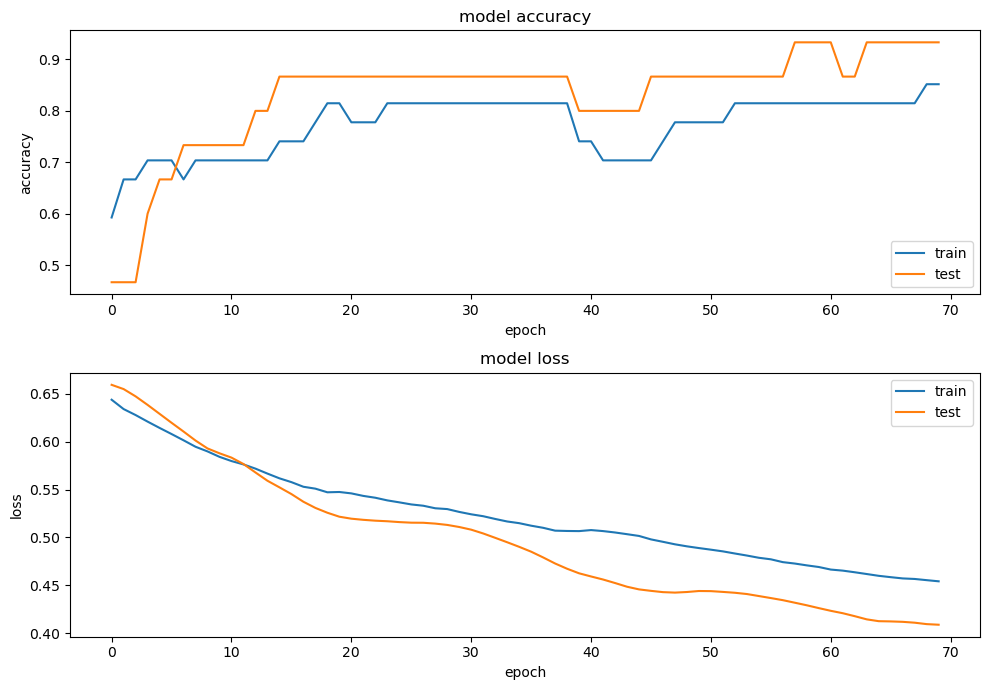

In [63]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [64]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

1/1 [==============================] - 0s 22ms/step
[0 4]


### MI have feature selection [ left right ]

In [184]:
# Transform data into CSP space

X_transformed = csp_mi.transform(X_mi)
df = pd.DataFrame(X_transformed)
print(X_transformed.shape)
print(X_transformed.size)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[best_subset], y_mi, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(42, 7)
294
(27, 2)
54


In [185]:
target = ['left','right']

#### **Logistic Regression**

In [186]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]



#### **Support Vector Machine**

In [187]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.8
precision: 0.8107142857142856
recall: 0.8
f1_score: 0.8018099547511313
              precision    recall  f1-score   support

        left       0.71      0.83      0.77         6
       right       0.88      0.78      0.82         9

    accuracy                           0.80        15
   macro avg       0.79      0.81      0.80        15
weighted avg       0.81      0.80      0.80        15

Confusion matrix 
[[5 1]
 [2 7]]



In [188]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]



#### **Linear Discriminant Analysis**

In [189]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]



#### **k-NN K Neighbors Classifier**

In [190]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.6666666666666666
precision: 0.7222222222222222
recall: 0.6666666666666666
f1_score: 0.6666666666666666
              precision    recall  f1-score   support

        left       0.56      0.83      0.67         6
       right       0.83      0.56      0.67         9

    accuracy                           0.67        15
   macro avg       0.69      0.69      0.67        15
weighted avg       0.72      0.67      0.67        15

Confusion matrix 
[[5 1]
 [4 5]]



#### **Multi-Layer Perceptron (MLP)**

In [191]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.4
precision: 0.16000000000000003
recall: 0.4
f1_score: 0.2285714285714286
              precision    recall  f1-score   support

        left       0.40      1.00      0.57         6
       right       0.00      0.00      0.00         9

    accuracy                           0.40        15
   macro avg       0.20      0.50      0.29        15
weighted avg       0.16      0.40      0.23        15

Confusion matrix 
[[6 0]
 [9 0]]



c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision an

#### **Convolution Neural Network (CNN)**

In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=2, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                96        
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 2)                 34        
                                                                 
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________


In [193]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

        2      3
0   False   True
1    True  False
2    True  False
3   False   True
4    True  False
5   False   True
6    True  False
7    True  False
8    True  False
9   False   True
10   True  False
11   True  False
12  False   True
13   True  False
14  False   True
15   True  False
16   True  False
17   True  False
18  False   True
19  False   True
20   True  False
21   True  False
22  False   True
23  False   True
24  False   True
25   True  False
26  False   True


In [194]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [195]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
2/2 [==============================] - 1s 215ms/step - loss: 0.6799 - accuracy: 0.5556 - val_loss: 0.7347 - val_accuracy: 0.4000
Epoch 2/70
2/2 [==============================] - 0s 33ms/step - loss: 0.6737 - accuracy: 0.5556 - val_loss: 0.7239 - val_accuracy: 0.4000
Epoch 3/70
2/2 [==============================] - 0s 31ms/step - loss: 0.6695 - accuracy: 0.5556 - val_loss: 0.7134 - val_accuracy: 0.4000
Epoch 4/70
2/2 [==============================] - 0s 32ms/step - loss: 0.6656 - accuracy: 0.5926 - val_loss: 0.7053 - val_accuracy: 0.4667
Epoch 5/70
2/2 [==============================] - 0s 31ms/step - loss: 0.6612 - accuracy: 0.5926 - val_loss: 0.6994 - val_accuracy: 0.4667
Epoch 6/70
2/2 [==============================] - 0s 29ms/step - loss: 0.6577 - accuracy: 0.5926 - val_loss: 0.6941 - val_accuracy: 0.4667
Epoch 7/70
2/2 [==============================] - 0s 32ms/step - loss: 0.6541 - accuracy: 0.5926 - val_loss: 0.6889 - val_accuracy: 0.4667
Epoch 8/70
2/2 [==========

In [196]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.5066745281219482
Train accuracy: 0.8148148059844971


In [197]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(2)
    elif i == 1:
        predicted_classes_str.append(3)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str)

1/1 [==============================] - 0s 68ms/step
Accuracy: 0.8666666666666667
precision: 0.8666666666666667
recall: 0.8666666666666667
f1_score: 0.8666666666666667
              precision    recall  f1-score   support

        left       0.83      0.83      0.83         6
       right       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15

Confusion matrix 
[[5 1]
 [1 8]]


In [198]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4750732183456421
Test accuracy: 0.8666666746139526


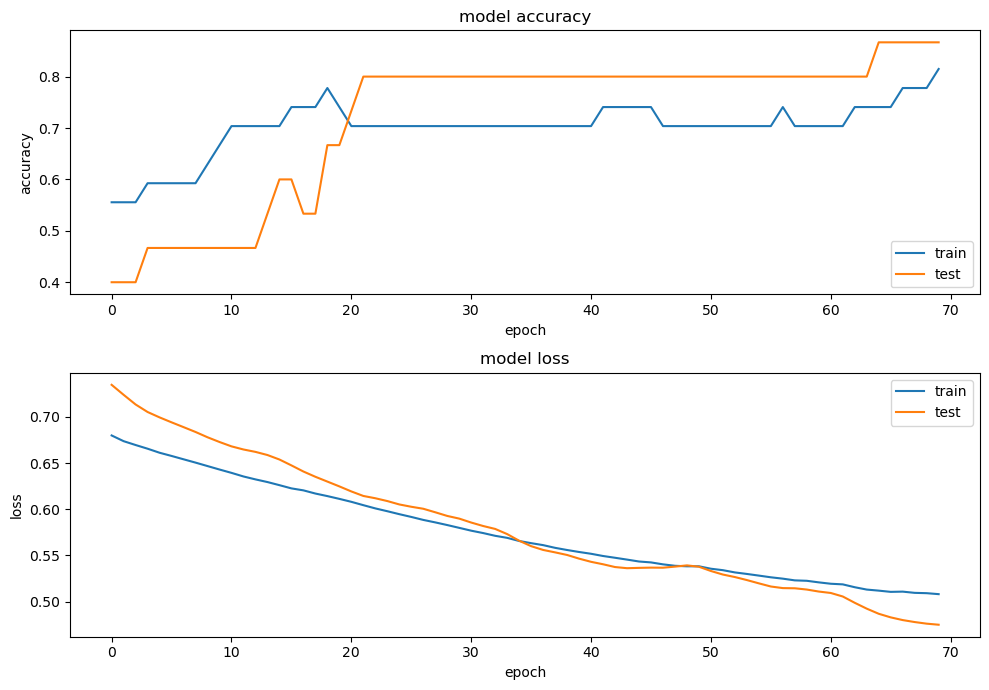

In [199]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [200]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

1/1 [==============================] - 0s 35ms/step
[ 0 13]


### MI no feature selection [ rest left right ]

In [202]:
# Transform data into CSP space

X_transformed = csp_nonmi.transform(X_nonmi)
print(X_transformed.shape)
print(X_transformed.size)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed , y_nonmi, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(84, 7)
588
(54, 7)
378


In [203]:
target = ['rest','left','right']

#### **Logistic Regression**

In [204]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.43333333333333335
precision: 0.41888888888888887
recall: 0.43333333333333335
f1_score: 0.42355889724310786
              precision    recall  f1-score   support

        rest       0.55      0.61      0.58        18
        left       0.00      0.00      0.00         4
       right       0.33      0.25      0.29         8

    accuracy                           0.43        30
   macro avg       0.29      0.29      0.29        30
weighted avg       0.42      0.43      0.42        30

Confusion matrix 
[[11  4  3]
 [ 3  0  1]
 [ 6  0  2]]



#### **Support Vector Machine**

In [205]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.5333333333333333
precision: 0.45666666666666667
recall: 0.5333333333333333
f1_score: 0.48205128205128206
              precision    recall  f1-score   support

        rest       0.58      0.78      0.67        18
        left       0.00      0.00      0.00         4
       right       0.40      0.25      0.31         8

    accuracy                           0.53        30
   macro avg       0.33      0.34      0.32        30
weighted avg       0.46      0.53      0.48        30

Confusion matrix 
[[14  1  3]
 [ 4  0  0]
 [ 6  0  2]]



In [206]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.5666666666666667
precision: 0.4888888888888889
recall: 0.5666666666666667
f1_score: 0.4799999999999999
              precision    recall  f1-score   support

        rest       0.59      0.89      0.71        18
        left       0.00      0.00      0.00         4
       right       0.50      0.12      0.20         8

    accuracy                           0.57        30
   macro avg       0.36      0.34      0.30        30
weighted avg       0.49      0.57      0.48        30

Confusion matrix 
[[16  1  1]
 [ 4  0  0]
 [ 7  0  1]]



#### **Linear Discriminant Analysis**

In [207]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.43333333333333335
precision: 0.4066276803118909
recall: 0.43333333333333335
f1_score: 0.41950185479597246
              precision    recall  f1-score   support

        rest       0.58      0.61      0.59        18
        left       0.00      0.00      0.00         4
       right       0.22      0.25      0.24         8

    accuracy                           0.43        30
   macro avg       0.27      0.29      0.28        30
weighted avg       0.41      0.43      0.42        30

Confusion matrix 
[[11  2  5]
 [ 2  0  2]
 [ 6  0  2]]



#### **k-NN K Neighbors Classifier**

In [208]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.5333333333333333
precision: 0.44166666666666665
recall: 0.5333333333333333
f1_score: 0.47301587301587306
              precision    recall  f1-score   support

        rest       0.62      0.83      0.71        18
        left       0.00      0.00      0.00         4
       right       0.25      0.12      0.17         8

    accuracy                           0.53        30
   macro avg       0.29      0.32      0.29        30
weighted avg       0.44      0.53      0.47        30

Confusion matrix 
[[15  1  2]
 [ 3  0  1]
 [ 6  1  1]]



#### **Multi-Layer Perceptron (MLP)**

In [209]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.4
precision: 0.45960784313725495
recall: 0.4
f1_score: 0.42490842490842495
              precision    recall  f1-score   support

        rest       0.59      0.56      0.57        18
        left       0.00      0.00      0.00         4
       right       0.40      0.25      0.31         8

    accuracy                           0.40        30
   macro avg       0.33      0.27      0.29        30
weighted avg       0.46      0.40      0.42        30

Confusion matrix 
[[10  5  3]
 [ 4  0  0]
 [ 3  3  2]]



c:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### **Convolution Neural Network (CNN)**

In [210]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=7, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                256       
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (None, 3)                 51        
                                                                 
Total params: 835
Trainable params: 835
Non-trainable params: 0
_________________________________________________________________


In [211]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

        1      2      3
0   False   True  False
1    True  False  False
2    True  False  False
3   False   True  False
4   False   True  False
5   False   True  False
6   False   True  False
7    True  False  False
8    True  False  False
9    True  False  False
10  False   True  False
11  False   True  False
12   True  False  False
13  False  False   True
14   True  False  False
15  False  False   True
16  False   True  False
17  False  False   True
18   True  False  False
19  False  False   True
20  False   True  False
21  False  False   True
22  False  False   True
23  False  False   True
24  False   True  False
25   True  False  False
26  False  False   True
27   True  False  False
28  False   True  False
29  False   True  False
30   True  False  False
31   True  False  False
32   True  False  False
33   True  False  False
34  False  False   True
35   True  False  False
36   True  False  False
37   True  False  False
38  False   True  False
39   True  False  False
40  False   True

In [212]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [213]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
3/3 [==============================] - 1s 108ms/step - loss: 1.0920 - accuracy: 0.4444 - val_loss: 1.0711 - val_accuracy: 0.5000
Epoch 2/70
3/3 [==============================] - 0s 17ms/step - loss: 1.0864 - accuracy: 0.5000 - val_loss: 1.0672 - val_accuracy: 0.5333
Epoch 3/70
3/3 [==============================] - 0s 17ms/step - loss: 1.0818 - accuracy: 0.5556 - val_loss: 1.0637 - val_accuracy: 0.5333
Epoch 4/70
3/3 [==============================] - 0s 18ms/step - loss: 1.0775 - accuracy: 0.5556 - val_loss: 1.0597 - val_accuracy: 0.5667
Epoch 5/70
3/3 [==============================] - 0s 20ms/step - loss: 1.0731 - accuracy: 0.5556 - val_loss: 1.0563 - val_accuracy: 0.5667
Epoch 6/70
3/3 [==============================] - 0s 17ms/step - loss: 1.0687 - accuracy: 0.5741 - val_loss: 1.0534 - val_accuracy: 0.5333
Epoch 7/70
3/3 [==============================] - 0s 18ms/step - loss: 1.0649 - accuracy: 0.5556 - val_loss: 1.0513 - val_accuracy: 0.6000
Epoch 8/70
3/3 [==========

In [214]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.7278326749801636
Train accuracy: 0.7407407164573669


In [215]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(1)
    elif i == 1:
        predicted_classes_str.append(2)
    elif i == 2:
        predicted_classes_str.append(3)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str, target)

1/1 [==============================] - 0s 58ms/step
Accuracy: 0.5333333333333333
precision: 0.4857142857142857
recall: 0.5333333333333333
f1_score: 0.5066666666666666
              precision    recall  f1-score   support

        rest       0.62      0.72      0.67        18
        left       0.00      0.00      0.00         4
       right       0.43      0.38      0.40         8

    accuracy                           0.53        30
   macro avg       0.35      0.37      0.36        30
weighted avg       0.49      0.53      0.51        30

Confusion matrix 
[[13  2  3]
 [ 3  0  1]
 [ 5  0  3]]


In [216]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9805217981338501
Test accuracy: 0.5333333611488342


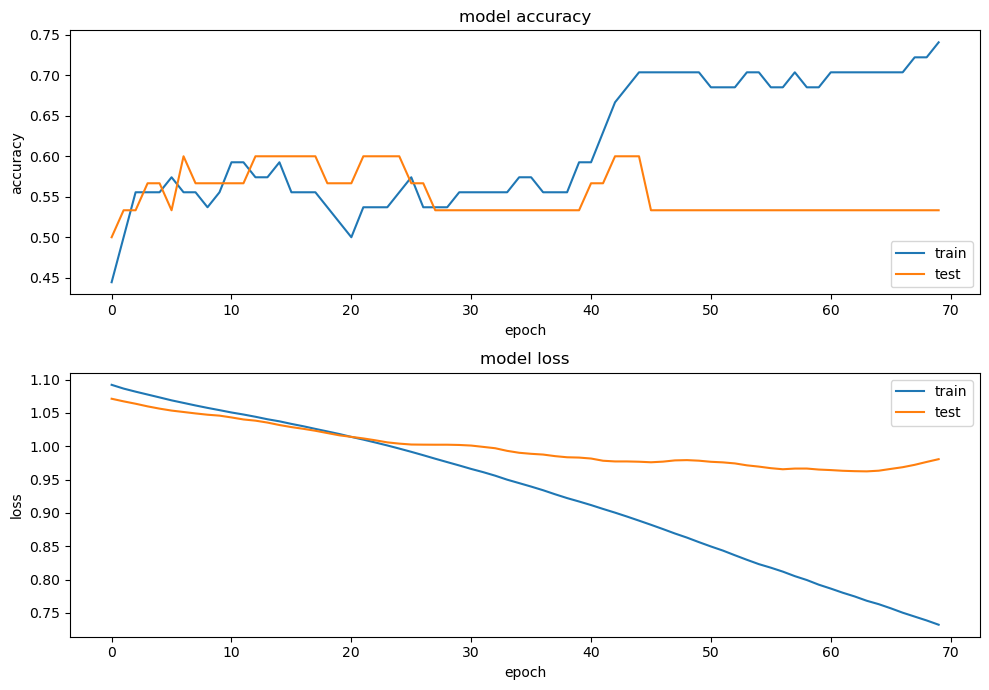

In [217]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [218]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

1/1 [==============================] - 0s 25ms/step
[24 26 12]


### MI no feature selection [ MI and non-MI ]

In [219]:
# Transform data into CSP space

X_transformed = csp_nonmi.transform(X_nonmi)
print(X_transformed.shape)
print(X_transformed.size)

y = [2 if x == 3 else x for x in y_nonmi]
print(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(84, 7)
588
[2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
(54, 7)
378


In [220]:
target = ['non-MI', 'MI']

#### **Logistic Regression**

In [221]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.4
precision: 0.16000000000000003
recall: 0.4
f1_score: 0.2285714285714286
              precision    recall  f1-score   support

      non-MI       0.00      0.00      0.00        18
          MI       0.40      1.00      0.57        12

    accuracy                           0.40        30
   macro avg       0.20      0.50      0.29        30
weighted avg       0.16      0.40      0.23        30

Confusion matrix 
[[ 0 18]
 [ 0 12]]



c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision an

#### **Support Vector Machine**

In [222]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.4
precision: 0.16000000000000003
recall: 0.4
f1_score: 0.2285714285714286
              precision    recall  f1-score   support

      non-MI       0.00      0.00      0.00        18
          MI       0.40      1.00      0.57        12

    accuracy                           0.40        30
   macro avg       0.20      0.50      0.29        30
weighted avg       0.16      0.40      0.23        30

Confusion matrix 
[[ 0 18]
 [ 0 12]]



c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision an

In [223]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.4
precision: 0.16000000000000003
recall: 0.4
f1_score: 0.2285714285714286
              precision    recall  f1-score   support

      non-MI       0.00      0.00      0.00        18
          MI       0.40      1.00      0.57        12

    accuracy                           0.40        30
   macro avg       0.20      0.50      0.29        30
weighted avg       0.16      0.40      0.23        30

Confusion matrix 
[[ 0 18]
 [ 0 12]]



c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision an

#### **Linear Discriminant Analysis**

In [224]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.5
precision: 0.5714285714285714
recall: 0.5
f1_score: 0.4848484848484848
              precision    recall  f1-score   support

      non-MI       0.67      0.33      0.44        18
          MI       0.43      0.75      0.55        12

    accuracy                           0.50        30
   macro avg       0.55      0.54      0.49        30
weighted avg       0.57      0.50      0.48        30

Confusion matrix 
[[ 6 12]
 [ 3  9]]



#### **k-NN K Neighbors Classifier**

In [225]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.6666666666666666
precision: 0.6599999999999999
recall: 0.6666666666666666
f1_score: 0.6602870813397127
              precision    recall  f1-score   support

      non-MI       0.70      0.78      0.74        18
          MI       0.60      0.50      0.55        12

    accuracy                           0.67        30
   macro avg       0.65      0.64      0.64        30
weighted avg       0.66      0.67      0.66        30

Confusion matrix 
[[14  4]
 [ 6  6]]



#### **Multi-Layer Perceptron (MLP)**

In [226]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.6666666666666666
precision: 0.6666666666666666
recall: 0.6666666666666666
f1_score: 0.6666666666666666
              precision    recall  f1-score   support

      non-MI       0.72      0.72      0.72        18
          MI       0.58      0.58      0.58        12

    accuracy                           0.67        30
   macro avg       0.65      0.65      0.65        30
weighted avg       0.67      0.67      0.67        30

Confusion matrix 
[[13  5]
 [ 5  7]]



#### **Convolution Neural Network (CNN)**

In [227]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=7, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                256       
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 2)                 34        
                                                                 
Total params: 818
Trainable params: 818
Non-trainable params: 0
_________________________________________________________________


In [228]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

        1      2
0   False   True
1    True  False
2    True  False
3   False   True
4   False   True
5   False   True
6   False   True
7    True  False
8    True  False
9    True  False
10  False   True
11  False   True
12   True  False
13  False   True
14   True  False
15  False   True
16  False   True
17  False   True
18   True  False
19  False   True
20  False   True
21  False   True
22  False   True
23  False   True
24  False   True
25   True  False
26  False   True
27   True  False
28  False   True
29  False   True
30   True  False
31   True  False
32   True  False
33   True  False
34  False   True
35   True  False
36   True  False
37   True  False
38  False   True
39   True  False
40  False   True
41   True  False
42   True  False
43   True  False
44  False   True
45  False   True
46  False   True
47   True  False
48   True  False
49  False   True
50  False   True
51  False   True
52  False   True
53   True  False


In [229]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [230]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
3/3 [==============================] - 1s 114ms/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6665 - val_accuracy: 0.6000
Epoch 2/70
3/3 [==============================] - 0s 24ms/step - loss: 0.6909 - accuracy: 0.5000 - val_loss: 0.6674 - val_accuracy: 0.6000
Epoch 3/70
3/3 [==============================] - 0s 19ms/step - loss: 0.6887 - accuracy: 0.5000 - val_loss: 0.6688 - val_accuracy: 0.5667
Epoch 4/70
3/3 [==============================] - 0s 17ms/step - loss: 0.6867 - accuracy: 0.5556 - val_loss: 0.6699 - val_accuracy: 0.5667
Epoch 5/70
3/3 [==============================] - 0s 18ms/step - loss: 0.6847 - accuracy: 0.5556 - val_loss: 0.6712 - val_accuracy: 0.5667
Epoch 6/70
3/3 [==============================] - 0s 18ms/step - loss: 0.6830 - accuracy: 0.6111 - val_loss: 0.6728 - val_accuracy: 0.5333
Epoch 7/70
3/3 [==============================] - 0s 17ms/step - loss: 0.6810 - accuracy: 0.6296 - val_loss: 0.6748 - val_accuracy: 0.5333
Epoch 8/70
3/3 [==========

In [231]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.5897548794746399
Train accuracy: 0.6851851940155029


In [232]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(1)
    elif i == 1:
        predicted_classes_str.append(2)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str, target)

1/1 [==============================] - 0s 56ms/step
Accuracy: 0.5333333333333333
precision: 0.6318181818181817
recall: 0.5333333333333333
f1_score: 0.5122171945701358
              precision    recall  f1-score   support

      non-MI       0.75      0.33      0.46        18
          MI       0.45      0.83      0.59        12

    accuracy                           0.53        30
   macro avg       0.60      0.58      0.52        30
weighted avg       0.63      0.53      0.51        30

Confusion matrix 
[[ 6 12]
 [ 2 10]]


In [233]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7126953601837158
Test accuracy: 0.5333333611488342


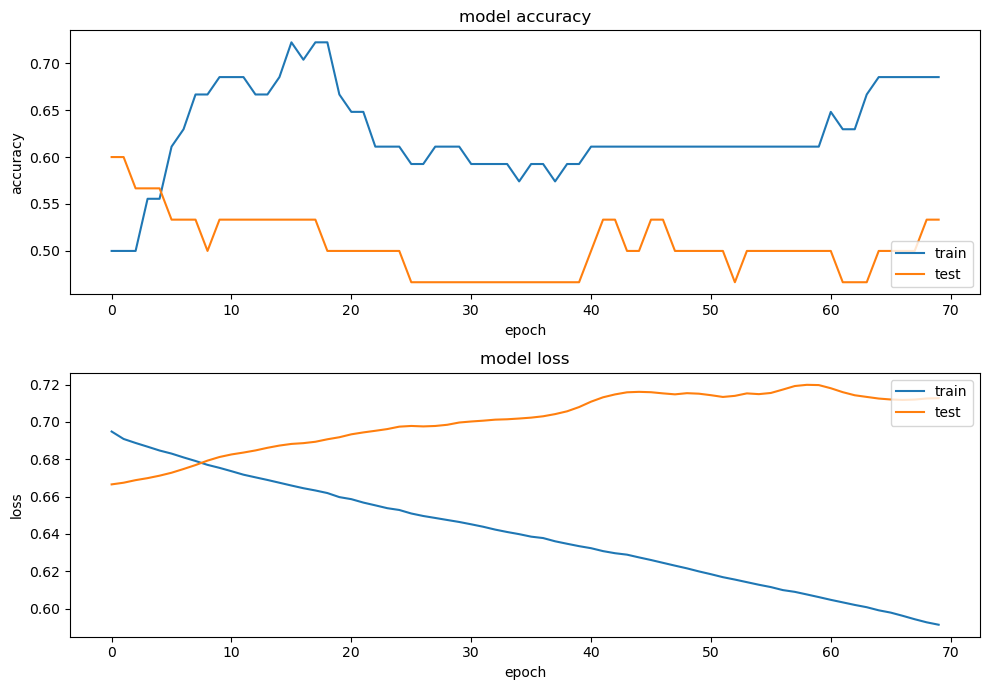

In [234]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [235]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

1/1 [==============================] - 0s 24ms/step
[24 27]


## Conclusion

It is possible to distinguish between left-right motor imagery classes, but there is an issue with classifying between Motor Imagery and Non-Motor Imagery. This poses a challenge in separating the differences between resting periods and periods of imagination.